In [2]:
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import urllib
import numpy as np
import PIL
import torch

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu" # 檢查是否有可用的 CUDA 設備（通常是顯卡，支援 GPU 運算），如果有，就將 device 變數設置為 "cuda"，否則設置為 "cpu"。

In [4]:
# path = '/content/drive/MyDrive/Colab Notebooks/dtransposed_diffusion_model/weight_save/model_checkpoint_epoch_{}.pth'

In [5]:
# for i in range(0, 96, 5):
#   checkpoint = torch.load(path.format(i))
#   print("At epoch {}, the loss is {}".format(checkpoint['epoch'], checkpoint['loss']))

In [6]:
# path = '/content/drive/MyDrive/Colab Notebooks/ dtransposed_diffusion_model/weight_saveepoch_0.pth'


In [7]:
def get_sample_image()-> PIL.Image.Image:
    url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTZmJy3aSZ1Ix573d2MlJXQowLCLQyIUsPdniOJ7rBsgG4XJb04g9ZFA9MhxYvckeKkVmo&usqp=CAU'
    filename = 'racoon.jpg'
    urllib.request.urlretrieve(url, filename)
    return PIL.Image.open(filename)

In [8]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [9]:
def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

In [10]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps

        """
        if
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]


        """
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device)

    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns
        the denoised image.
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in `t`
        """
        result = values.gather(-1, t.cpu())
        """
        if
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3

        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)

        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)



In [11]:
IMAGE_SHAPE = (32, 32)

In [12]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE), # Resize the input image
    transforms.ToTensor(), # Convert to torch tensor (scales data into [0,1])
    transforms.Lambda(lambda t: (t * 2) - 1), # Scale data between [-1, 1]
])


reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2), # Scale data between [0,1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.Lambda(lambda t: t * 255.), # Scale data between [0.,255.]
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # Convert into an uint8 numpy array
    transforms.ToPILImage(), # Convert to PIL image
])


In [13]:
pil_image = get_sample_image()
torch_image = transform(pil_image)

In [14]:
jpeg_image = pil_image
print("Image format:", jpeg_image.format)
print("Image size:", jpeg_image.size)
print("Image mode:", jpeg_image.mode)

Image format: JPEG
Image size: (280, 180)
Image mode: RGB


In [15]:
diffusion_model = DiffusionModel()

<Figure size 1500x1500 with 0 Axes>

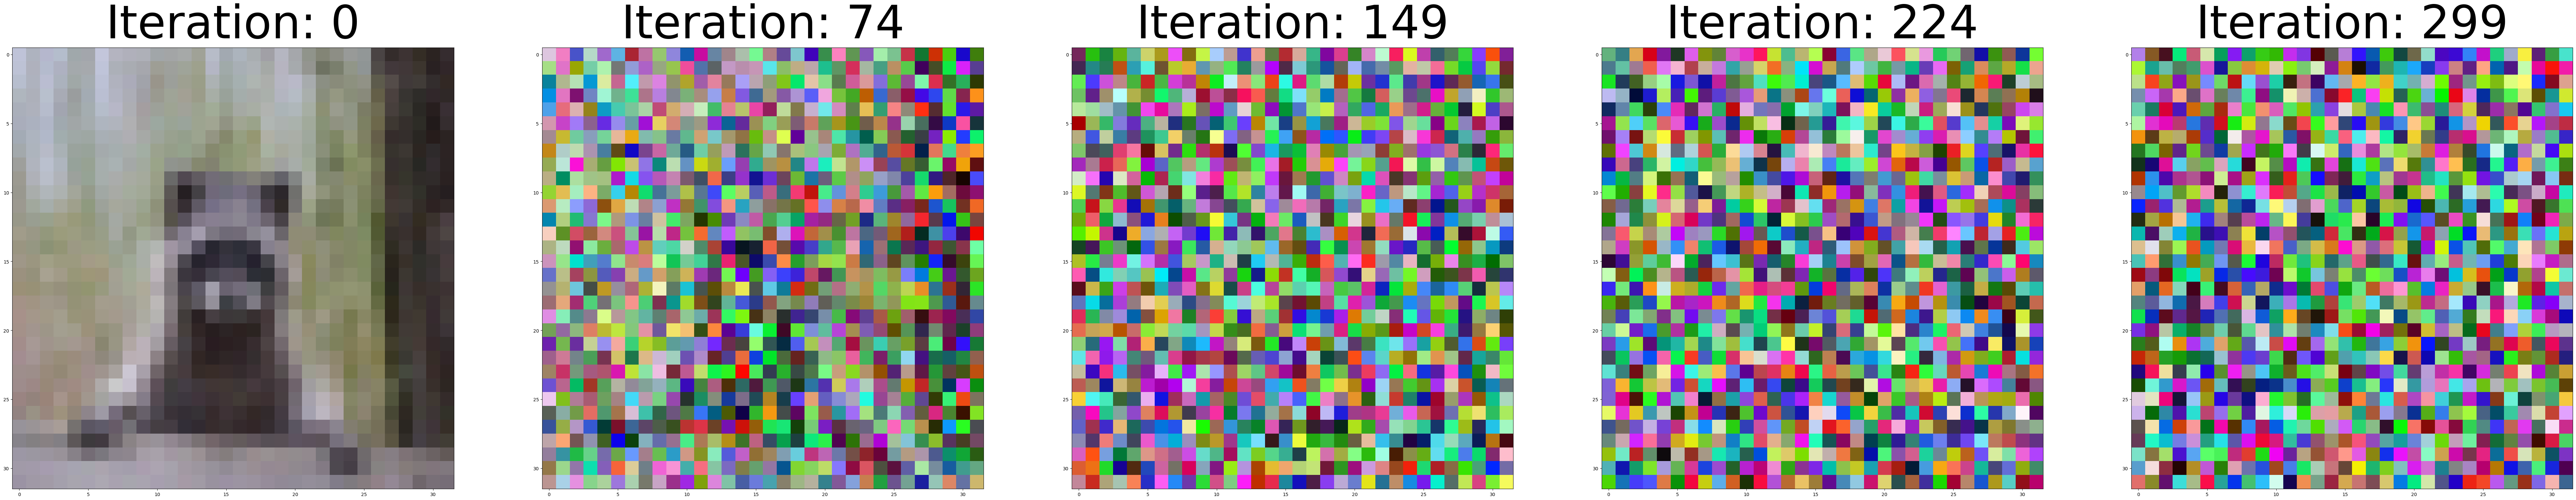

In [16]:
NO_DISPLAY_IMAGES = 5
torch_image_batch = torch.stack([torch_image] * NO_DISPLAY_IMAGES)
t = torch.linspace(0, diffusion_model.timesteps - 1, NO_DISPLAY_IMAGES).long()
noisy_image_batch, _ = diffusion_model.forward(torch_image_batch, t, device)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(1, NO_DISPLAY_IMAGES, figsize = (100,100))

for idx, image in enumerate(noisy_image_batch):
    ax[idx].imshow(reverse_transform(image))
    ax[idx].set_title(f"Iteration: {t[idx].item()}", fontsize = 100)
plt.show()


In [17]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [18]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()

        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out) # 用來對label embedded的layer

        self.downsample = downsample

        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1) # size不變
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1) # 這邊會讓size變成一半
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1) # size unchanged
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1) # double the size

        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)

        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1) # size unchanged
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels: # 若data有附上label則把label也embedded進去
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]

        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)

In [19]:
class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)

        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1) # 把3色轉成sequence_chnnels[0], 也就是unet的第一層
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1) # unet的最後一層，轉回三色


    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)

        return self.conv2(o)

In [20]:
# for test
'''
NO_EPOCHS = 2000
PRINT_FREQUENCY = 400
LR = 0.001
BATCH_SIZE = 128
VERBOSE = True

unet = UNet(labels=False)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)
'''

'\nNO_EPOCHS = 2000\nPRINT_FREQUENCY = 400\nLR = 0.001\nBATCH_SIZE = 128\nVERBOSE = True\n\nunet = UNet(labels=False)\nunet.to(device)\noptimizer = torch.optim.Adam(unet.parameters(), lr=LR)\n'

In [21]:
'''
# 此block為單純使用一張圖片來做training
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []

    batch = torch.stack([torch_image] * BATCH_SIZE)
    t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)

    batch_noisy, noise = diffusion_model.forward(batch, t, device)
    predicted_noise = unet(batch_noisy, t)

    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(noise, predicted_noise)
    mean_epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()

    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)
  '''

'\n# 此block為單純使用一張圖片來做training\nfor epoch in range(NO_EPOCHS):\n    mean_epoch_loss = []\n\n    batch = torch.stack([torch_image] * BATCH_SIZE)\n    t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)\n\n    batch_noisy, noise = diffusion_model.forward(batch, t, device)\n    predicted_noise = unet(batch_noisy, t)\n\n    optimizer.zero_grad()\n    loss = torch.nn.functional.mse_loss(noise, predicted_noise)\n    mean_epoch_loss.append(loss.item())\n    loss.backward()\n    optimizer.step()\n\n    if epoch % PRINT_FREQUENCY == 0:\n        print(\'---\')\n        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")\n        if VERBOSE:\n            with torch.no_grad():\n                plot_noise_prediction(noise[0], predicted_noise[0])\n                plot_noise_distribution(noise, predicted_noise)\n  '

In [22]:
# for test
'''
with torch.no_grad():
    img = torch.randn((1, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        img = diffusion_model.backward(img, t, unet.eval())
        #unet.eval() 會將神經網絡的模式切換為測試模式，這樣模型就不會應用訓練時的一些技巧。具體來說，eval() 操作會將 dropout 禁用，並使用測試時的 batch normalization 參數。總結起來，unet.eval() 的目的是確保在進行推斷時，模型不應用訓練時的一些隨機性技巧，以確保獲得穩定和可重複的預測結果。
        if i % 50 == 0:
            plt.figure(figsize=(2,2))
            plt.imshow(reverse_transform(img[0]))
            plt.show()
'''

'\nwith torch.no_grad():\n    img = torch.randn((1, 3) + IMAGE_SHAPE).to(device)\n    for i in reversed(range(diffusion_model.timesteps)):\n        t = torch.full((1,), i, dtype=torch.long, device=device)\n        img = diffusion_model.backward(img, t, unet.eval())\n        #unet.eval() 會將神經網絡的模式切換為測試模式，這樣模型就不會應用訓練時的一些技巧。具體來說，eval() 操作會將 dropout 禁用，並使用測試時的 batch normalization 參數。總結起來，unet.eval() 的目的是確保在進行推斷時，模型不應用訓練時的一些隨機性技巧，以確保獲得穩定和可重複的預測結果。\n        if i % 50 == 0:\n            plt.figure(figsize=(2,2))\n            plt.imshow(reverse_transform(img[0]))\n            plt.show()\n'

In [23]:
BATCH_SIZE = 256
NO_EPOCHS = 100
PRINT_FREQUENCY = 5
LR = 0.001
VERBOSE = False

unet = UNet(labels=True)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [24]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, drop_last=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 28910921.13it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [25]:
# first epoch
'''
import shutil
from google.colab import files

for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    for batch, label in trainloader:
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device)) # 把labels從(256)轉成(256, 1)

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    for batch, label in testloader:

        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)

        batch_noisy, noise = diffusion_model.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

        val_loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        mean_epoch_loss_val.append(val_loss.item())

    if epoch % PRINT_FREQUENCY == 0:
        checkpoint = {
          'epoch': epoch,
          'model_state_dict': unet.state_dict(), # model.state_dict()是存下param的的值和形狀
          'optimizer_state_dict': optimizer.state_dict(), # optimizer.state_dict()則是存下優化器的param如momentum等等 不包含當下梯度
          'valid_loss' : np.mean(mean_epoch_loss_val),
          'loss' : np.mean(mean_epoch_loss) # 記得不能存tensor
        }

        torch.save(checkpoint, 'model_checkpoint_epoch_{}.pth'.format(epoch))
        source_path = 'model_checkpoint_epoch_{}.pth'.format(epoch)
        destination_path = '/content/drive/MyDrive/Colab Notebooks/dtransposed_diffusion_model/weight_save'


        # save them to the google drive
        shutil.copy(source_path, destination_path)
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)
        # save_path = "/content/drive/MyDrive/Colab Notebooks/ dtransposed_diffusion_model/weight_save"
        # torch.save(unet.state_dict(), f"{save_path}epoch_{epoch}.pth")
        # torch.save(unet.state_dict(), f"epoch: {epoch}")
'''

'\nimport shutil\nfrom google.colab import files\n\nfor epoch in range(NO_EPOCHS):\n    mean_epoch_loss = []\n    mean_epoch_loss_val = []\n    for batch, label in trainloader:\n        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)\n        batch = batch.to(device)\n        batch_noisy, noise = diffusion_model.forward(batch, t, device)\n        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device)) # 把labels從(256)轉成(256, 1)\n\n        optimizer.zero_grad()\n        loss = torch.nn.functional.mse_loss(noise, predicted_noise)\n        mean_epoch_loss.append(loss.item())\n        loss.backward()\n        optimizer.step()\n\n    for batch, label in testloader:\n\n        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)\n        batch = batch.to(device)\n\n        batch_noisy, noise = diffusion_model.forward(batch, t, device)\n        predicted_noise = unet(batch_noisy, t, labels = label.resh

In [26]:
# continue training

import shutil
from google.colab import files
initial = 210
NO_EPOCHS = 200 # 要多做幾個epochs
load_path = '/content/drive/MyDrive/Colab Notebooks/dtransposed_diffusion_model/weight_save/model_checkpoint_epoch_{}.pth'.format(initial) # 位置要改
checkpoint = torch.load(load_path)

start = checkpoint['epoch'] + 1
model_state_dict = checkpoint['model_state_dict']

unet.load_state_dict(model_state_dict)

for epoch in range(start , start + NO_EPOCHS + 1):
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    for batch, label in trainloader:
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device)) # 把labels從(256)轉成(256, 1)

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    for batch, label in testloader:

        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)

        batch_noisy, noise = diffusion_model.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

        val_loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        mean_epoch_loss_val.append(val_loss.item())

    if epoch % PRINT_FREQUENCY == 0:
        checkpoint = {
          'epoch': epoch,
          'model_state_dict': unet.state_dict(), # model.state_dict()是存下param的的值和形狀
          'optimizer_state_dict': optimizer.state_dict(), # optimizer.state_dict()則是存下優化器的param如momentum等等 不包含當下梯度
          'valid_loss' : np.mean(mean_epoch_loss_val),
          'loss' : np.mean(mean_epoch_loss) # 記得不能存tensor
        }

        torch.save(checkpoint, 'model_checkpoint_epoch_{}.pth'.format(epoch))
        source_path = 'model_checkpoint_epoch_{}.pth'.format(epoch)
        destination_path = '/content/drive/MyDrive/Colab Notebooks/dtransposed_diffusion_model/weight_save'


        # save them to the google drive
        shutil.copy(source_path, destination_path)

        #-----以下是存loss的---vvv
        checkpoint = {
          'epoch': epoch,
          'valid_loss' : np.mean(mean_epoch_loss_val),
          'loss' : np.mean(mean_epoch_loss) # 記得不能存tensor
        }

        torch.save(checkpoint, 'model_checkpoint_loss_epoch_{}.pth'.format(epoch))
        source_path = 'model_checkpoint_loss_epoch_{}.pth'.format(epoch)
        destination_path = '/content/drive/MyDrive/Colab Notebooks/dtransposed_diffusion_model/loss_save'


        # save them to the google drive
        shutil.copy(source_path, destination_path)
        #-----以下是存loss的---^^^


        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)
        # save_path = "/content/drive/MyDrive/Colab Notebooks/ dtransposed_diffusion_model/weight_save"
        # torch.save(unet.state_dict(), f"{save_path}epoch_{epoch}.pth")
        # torch.save(unet.state_dict(), f"epoch: {epoch}")

---
Epoch: 215 | Train Loss 0.05756871919983472 | Val Loss 0.05757295827452953
---
Epoch: 220 | Train Loss 0.05653619838830752 | Val Loss 0.05787855998063699
---
Epoch: 225 | Train Loss 0.05795092087907669 | Val Loss 0.05732509952325087
---
Epoch: 230 | Train Loss 0.05778968108770175 | Val Loss 0.05910519806620402
---
Epoch: 235 | Train Loss 0.05747667566323892 | Val Loss 0.05922188371037825
---
Epoch: 240 | Train Loss 0.057566904716002634 | Val Loss 0.05924103256219473
---
Epoch: 245 | Train Loss 0.05742458015298232 | Val Loss 0.0591907506951919
---
Epoch: 250 | Train Loss 0.05708203886946042 | Val Loss 0.059266307415106356
---
Epoch: 255 | Train Loss 0.05749075108995805 | Val Loss 0.05729154755289738
---
Epoch: 260 | Train Loss 0.05748962284280704 | Val Loss 0.05568696482059283
---
Epoch: 265 | Train Loss 0.05737210181661141 | Val Loss 0.057748654713997476


KeyboardInterrupt: 

In [4]:
from google.colab import runtime
runtime.unassign()

In [3]:
import torch
for i in range (1000):
  try:
    path = '/content/drive/MyDrive/Colab Notebooks/dtransposed_diffusion_model/loss_save/model_checkpoint_loss_epoch_{}.pth'.format(i)
    checkpoint = torch.load(path)

    print('epoch {} : loss = {:.10f}'.format(checkpoint['epoch'], checkpoint['loss']))
  except FileNotFoundError:
    a=1

epoch 110 : loss = 0.0583134262
epoch 115 : loss = 0.0587586917
epoch 120 : loss = 0.0593339199
epoch 125 : loss = 0.0588067979
epoch 130 : loss = 0.0587664894
epoch 135 : loss = 0.0586907878
epoch 140 : loss = 0.0584591499
epoch 145 : loss = 0.0584178460
epoch 150 : loss = 0.0583201411
epoch 155 : loss = 0.0584037188
epoch 160 : loss = 0.0582185327
epoch 165 : loss = 0.0582782795
epoch 170 : loss = 0.0585312056
epoch 175 : loss = 0.0578689772
epoch 180 : loss = 0.0581320329
epoch 185 : loss = 0.0576811122
epoch 190 : loss = 0.0580901685
epoch 195 : loss = 0.0578361436
epoch 200 : loss = 0.0576689972
epoch 205 : loss = 0.0580770106
epoch 210 : loss = 0.0584174873
epoch 215 : loss = 0.0575687192
epoch 220 : loss = 0.0565361984
epoch 225 : loss = 0.0579509209
epoch 230 : loss = 0.0577896811
epoch 235 : loss = 0.0574766757
epoch 240 : loss = 0.0575669047
epoch 245 : loss = 0.0574245802
epoch 250 : loss = 0.0570820389
epoch 255 : loss = 0.0574907511
epoch 260 : loss = 0.0574896228
epoch 26

In [ ]:
unet = UNet(labels=True)
unet.load_state_dict(torch.load(("epoch: 80")))

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
NUM_CLASSES = len(classes)
NUM_DISPLAY_IMAGES = 5

In [ ]:
torch.manual_seed(16)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(NUM_CLASSES, NUM_DISPLAY_IMAGES, figsize = (100,100))

for c in range(NUM_CLASSES):
    imgs = torch.randn((NUM_DISPLAY_IMAGES, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([c] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
        imgs = diffusion_model.backward(x=imgs, t=t, model=unet.eval().to(device), labels = labels)
    for idx, img in enumerate(imgs):
        ax[c][idx].imshow(reverse_transform(img))
        ax[c][idx].set_title(f"Class: {classes[c]}", fontsize = 100)

plt.show()